# Assignment 4

In [1]:
import pandas as pd

## Toy Example

Download `SPECTF.train` and `SPECTF.test` from https://archive.ics.uci.edu/ml/machine-learning-databases/spect/

In [2]:
df_train = pd.read_csv('data/SPECTF.train', header=None)
df_test = pd.read_csv('data/SPECTF.test', header=None)

x_train = df_train.drop(0, axis=1)
y_train = df_train[0]
x_test = df_test.drop(0, axis=1)
y_test = df_test[0]

print(x_train.shape, x_test.shape)
print(y_train.mean(), y_test.mean())

(80, 44) (187, 44)
0.5 0.9197860962566845


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

rf = RandomForestClassifier(n_estimators=5, max_depth=2)

distributions = dict(n_estimators=range(1, 30), max_depth=range(1, 30))
clf = RandomizedSearchCV(rf, distributions, random_state=0, n_iter=100, n_jobs=-1, cv=15)
search = clf.fit(x_train, y_train)
search.best_params_

{'n_estimators': 14, 'max_depth': 6}

In [4]:
from sklearn.metrics import roc_auc_score

print(f'ROC AUC score:') 
print(f'train - {roc_auc_score(y_train, search.best_estimator_.predict(x_train))}')
print(f'test - {roc_auc_score(y_test, search.best_estimator_.predict(x_test))}')

ROC AUC score:
train - 1.0
test - 0.7170542635658915


## Gene Selection for Cancer Classification using Support Vector Machines

In [5]:
from sklearn.svm import SVC, LinearSVC
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
class SVMFS:
    def __init__(self, svm_max_iter=10_000_000, verbose=0):
        self.svm = SVC(kernel='linear', max_iter=svm_max_iter)
        self.r = None
        self.verbose = verbose
    
    def fit(self, x: pd.DataFrame, y):
        X_0 = x
        s = list(X_0.columns)
        r = []        

        while len(s) > 0:
            if self.verbose > 0:
                print(f'\r  ', end='')
                print(f'\r{len(s)}', end='')
                
            self.svm.fit(X_0[s], y)
            
            alphas = np.zeros(len(x))
            alphas[self.svm.support_] = self.svm.dual_coef_
            w = alphas @ X_0[s].values
            c = w ** 2

            f = np.argmin(c)
            r.append(s[f])
            s.remove(s[f])
        
        self.r = r[::-1]

In [7]:
svm_fs = SVMFS()
svm_fs.fit(x_train, y_train)

In [8]:
importance = svm_fs.r
score = []
n = len(importance)
for i in tqdm(range(n)):
    i = len(svm_fs.r) - i
    rf = RandomForestClassifier()
    distributions = dict(n_estimators=range(1, 30), max_depth=range(1, 30))
    clf = RandomizedSearchCV(rf, distributions, random_state=0, n_iter=100, n_jobs=-1, cv=5, scoring='roc_auc')
    search = clf.fit(x_train[importance[:i]], y_train)
    search.best_params_
    
    train_score = clf.best_score_
    test_score = roc_auc_score(y_test, search.best_estimator_.predict(x_test[importance[:i]]))
    score.append((train_score, test_score))

100%|███████████████████████████████████████████| 44/44 [01:16<00:00,  1.74s/it]


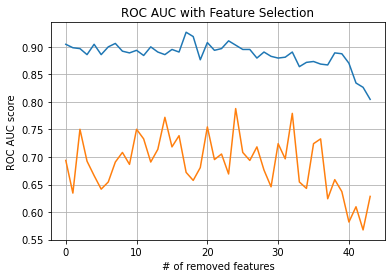

In [9]:
plt.title('ROC AUC with Feature Selection')
plt.plot(np.array(score).T[0])
plt.plot(np.array(score).T[1])
plt.xlabel('# of removed features')
plt.ylabel('ROC AUC score')
plt.grid()
plt.show()

In [10]:
best = sorted(score, key=lambda x: x[0], reverse=True)
print('validation best: {:.4f}, test: {:.4f}, {} features were removed.'.format(*best[0], score.index(best[0])))

validation best: 0.9266, test: 0.6721, 17 features were removed.


## TMGWA

In [11]:
def fitness(error_rate, feature_percent, alpha=0.999):
    beta = 1 - alpha
    return alpha * error_rate + beta * feature_percent

In [12]:
n_agents = 10

wolfs = (np.random.rand(n_agents, len(x_train.columns)) > .5).astype(float)

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

def calculate_error_rate(x_train, y_train, kf_n_splits=10, knn_n_neighbors=5):
    kf = KFold(n_splits=kf_n_splits, shuffle=True, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=knn_n_neighbors)

    predictions = []
    gt = []

    for train_index, val_index in kf.split(x_train):
        x_train_i = x_train.iloc[train_index]
        y_train_i = y_train.iloc[train_index]
        x_val_i = x_train.iloc[val_index]
        y_val_i = y_train.iloc[val_index]

        knn.fit(x_train_i, y_train_i)
        predictions.extend(knn.predict(x_val_i).tolist())
        gt.extend(y_val_i.tolist())

    error_rate = (np.array(predictions) != np.array(gt)).mean()
    return error_rate

In [14]:
def one_wolf_fitness(x_train, y_train, wolf):
    error_rate = calculate_error_rate(x_train.iloc[:, wolf], y_train)
    return fitness(error_rate, wolf.mean())

In [15]:
t = 0
iterations = 100
n = len(x_train.columns)

a = 2 - t * 2 / iterations
A = 2 * a * np.random.rand(n) - a
C = 2 * np.random.rand(n)

In [16]:
fitnesses = [one_wolf_fitness(x_train, y_train, wolf) for wolf in wolfs]
sorted_index = np.argsort(fitnesses)
x_alpha, x_beta, x_delta = [wolfs[i] for i in sorted_index[:3]]

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.82it/s]


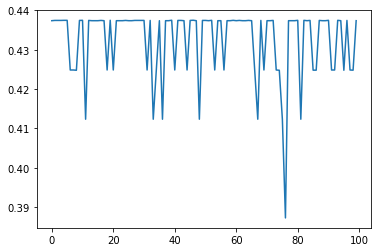

In [17]:
fitness_list = []
best_results = [-1, 1]

for t in tqdm(range(iterations)):
    x_abd = np.stack([x_alpha, x_beta, x_delta]).copy()

    a = 2 - t * 2 / iterations
    A = 2 * a * np.random.rand(3, n)
    C = 2 * np.random.rand(3, n)

    for wolf_ind in sorted_index:
        wolf = wolfs[wolf_ind]        
        D = C * x_abd  - wolf
        
        X_123 = x_abd - A * D
        wolfs[wolf_ind] = X_123.mean(axis=0)
        
    x_si = 1 / (1 + np.exp(-wolfs))
    x_binary = np.random.rand(*wolfs.shape) >= x_si
    wolfs[:] = x_binary
    
    fitnesses = [one_wolf_fitness(x_train, y_train, wolf) for wolf in wolfs]
    sorted_index = np.argsort(fitnesses)
    x_alpha, x_beta, x_delta = [wolfs[i] for i in sorted_index[:3]]
    
    if min(fitnesses) < best_results[1]:
        best_results[1] = min(fitnesses)
        best_results[0] = x_alpha.copy()
    
    fitness_list.append(min(fitnesses))
plt.plot(fitness_list)

In [18]:
rf = RandomForestClassifier()
distributions = dict(n_estimators=range(1, 30), max_depth=range(1, 30))
clf = RandomizedSearchCV(rf, distributions, random_state=0, n_iter=100, n_jobs=-1, cv=15)
search = clf.fit(x_train.iloc[:, best_results[0]], y_train)
search.best_params_

{'n_estimators': 3, 'max_depth': 2}

In [19]:
from sklearn.metrics import roc_auc_score

print(f'ROC AUC score:') 
print(f'train - {roc_auc_score(y_train, search.best_estimator_.predict(x_train.iloc[:, best_results[0]]))}')
print(f'test - {roc_auc_score(y_test, search.best_estimator_.predict(x_test.iloc[:, best_results[0]]))}')

ROC AUC score:
train - 0.6499999999999999
test - 0.488953488372093


## Baselines

The baselines:
 - mRMR
 - f_classif with false discovery rate of 10% - with SelectFdr function
 - RFE with SVM evaluation model
 - ReliefF

### MRMR

In [20]:
from mrmr import mrmr_classif

score = []
n = len(x_train.columns)
for i in tqdm(range(n)):    
    selected_features = mrmr_classif(x_train, y_train, K=n-i, show_progress=False)

    rf = RandomForestClassifier()
    distributions = dict(n_estimators=range(1, 30), max_depth=range(1, 30))
    clf = RandomizedSearchCV(rf, distributions, random_state=0, n_iter=100, n_jobs=-1, cv=5, scoring='roc_auc')
    search = clf.fit(x_train[selected_features], y_train)
    search.best_params_
    
    train_score = clf.best_score_
    test_score = roc_auc_score(y_test, search.best_estimator_.predict(x_test[selected_features]))
    score.append((train_score, test_score))

100%|███████████████████████████████████████████| 44/44 [01:34<00:00,  2.16s/it]


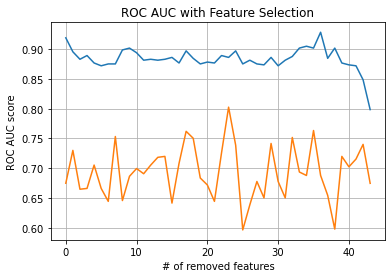

In [21]:
plt.title('ROC AUC with Feature Selection')
plt.plot(np.array(score).T[0])
plt.plot(np.array(score).T[1])
plt.xlabel('# of removed features')
plt.ylabel('ROC AUC score')
plt.grid()
plt.show()

In [22]:
best = sorted(score, key=lambda x: x[0], reverse=True)
print('validation best: {:.4f}, test: {:.4f}, {} features were removed.'.format(*best[0], score.index(best[0])))

validation best: 0.9281, test: 0.6880, 36 features were removed.


### F-Classif

In [23]:
from sklearn.feature_selection import SelectFdr
from sklearn.metrics import roc_auc_score

class RandomForestClassifierWithFDR(RandomForestClassifier):
    def __init__(self, n_estimators=10, max_depth=5, alpha=0.1):
        self.alpha = alpha
        self.selected_feautures = None
        self.fs = SelectFdr(alpha=alpha)
        
        super().__init__(n_estimators=n_estimators, max_depth=max_depth)
    
    def fit(self, X, y):
        X = self.fs.fit_transform(X, y)
        self.n_features_out_ = X.shape[1]
        super().fit(X, y)
    
    def predict(self, X):
        X = self.fs.transform(X)
        return super().predict(X)
    
    def predict_proba(self, X):
        X = self.fs.transform(X)
        return super().predict_proba(X)
    
    def score(self, X, y):
        return roc_auc_score(y, self.predict_proba(X)[:, 1])

In [24]:
rf = RandomForestClassifierWithFDR(alpha=0.1)
distributions = dict(n_estimators=range(1, 30), max_depth=range(1, 30))
clf = RandomizedSearchCV(rf, distributions, random_state=0, n_iter=100, n_jobs=-1, cv=5, scoring='roc_auc')

search = clf.fit(x_train, y_train)
search.best_params_

train_score = clf.best_score_
test_score = search.best_estimator_.score(x_test, y_test)
print('validation best: {:.4f}, test: {:.4f}, {} features remained.'.format(train_score, test_score, clf.best_estimator_.n_features_out_))

validation best: 0.8797, test: 0.7845, 24 features remained.


### ReliefF

In [25]:
from ReliefF import ReliefF

class RandomForestClassifierWithReliefF(RandomForestClassifier):
    def __init__(self, n_estimators=10, max_depth=5, n_neighbors=20, n_features_to_keep=2):
        self.n_neighbors = n_neighbors
        self.n_features_to_keep = n_features_to_keep
        
        self.selected_feautures = None
        self.fs = ReliefF(n_neighbors=n_neighbors, n_features_to_keep=n_features_to_keep)
        
        super().__init__(n_estimators=n_estimators, max_depth=max_depth)
    
    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
            y = y.values
        X = self.fs.fit_transform(X, y)
        self.n_features_out_ = X.shape[1]
        super().fit(X, y)
    
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        X = self.fs.transform(X)
        return super().predict(X)
    
    def predict_proba(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        X = self.fs.transform(X)
        return super().predict_proba(X)
    
    def score(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
            y = y.values
        return roc_auc_score(y, self.predict_proba(X)[:, 1])

In [26]:
rf = RandomForestClassifierWithReliefF()
distributions = dict(n_estimators=range(1, 30), max_depth=range(1, 30), n_neighbors=range(5, 40), n_features_to_keep=range(1, x_train.shape[1]))
clf = RandomizedSearchCV(rf, distributions, random_state=0, n_iter=100, n_jobs=-1, cv=5, scoring='roc_auc')

search = clf.fit(x_train, y_train)
search.best_params_

train_score = clf.best_score_
test_score = search.best_estimator_.score(x_test, y_test)
print('validation best: {:.4f}, test: {:.4f}, {} features remained.'.format(train_score, test_score, clf.best_estimator_.n_features_out_))

validation best: 0.7734, test: 0.7843, 28 features remained.
